# Temporal-Difference Methods

In this notebook, you will write your own implementations of many Temporal-Difference (TD) methods.

While we have provided some starter code, you are welcome to erase these hints and write your code from scratch.

---

### Part 0: Explore CliffWalkingEnv

We begin by importing the necessary packages.

In [8]:
import sys
import gym
import numpy as np
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline

import check_test
from plot_utils import plot_values

Use the code cell below to create an instance of the [CliffWalking](https://github.com/openai/gym/blob/master/gym/envs/toy_text/cliffwalking.py) environment.

In [9]:
env = gym.make('CliffWalking-v0')

The agent moves through a $4\times 12$ gridworld, with states numbered as follows:
```
[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
 [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23],
 [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35],
 [36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]]
```
At the start of any episode, state `36` is the initial state.  State `47` is the only terminal state, and the cliff corresponds to states `37` through `46`.

The agent has 4 potential actions:
```
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3
```

Thus, $\mathcal{S}^+=\{0, 1, \ldots, 47\}$, and $\mathcal{A} =\{0, 1, 2, 3\}$.  Verify this by running the code cell below.

In [10]:
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(48)


In this mini-project, we will build towards finding the optimal policy for the CliffWalking environment.  The optimal state-value function is visualized below.  Please take the time now to make sure that you understand _why_ this is the optimal state-value function.

_**Note**: You can safely ignore the values of the cliff "states" as these are not true states from which the agent can make decisions.  For the cliff "states", the state-value function is not well-defined._

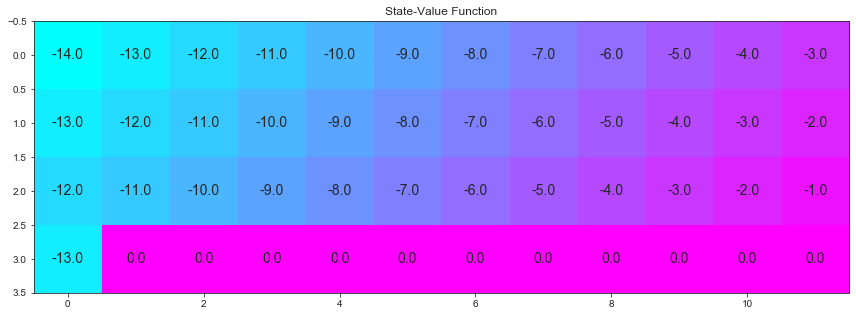

In [11]:
# define the optimal state-value function
V_opt = np.zeros((4,12))
V_opt[0][0:13] = -np.arange(3, 15)[::-1]
V_opt[1][0:13] = -np.arange(3, 15)[::-1] + 1
V_opt[2][0:13] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13

plot_values(V_opt)

### Part 1: TD Control: Sarsa

In this section, you will write your own implementation of the Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [12]:
def update_Q_sarsa(alpha, gamma, Q, state, action, reward, next_state=None, next_action=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = Q[next_state][next_action] if next_state is not None else 0    
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """
    if random.random() > eps: # select greedy action with probability epsilon
        return np.argmax(Q[state])
    else:                     # otherwise, select an action randomly
        return random.choice(np.arange(env.action_space.n))

In [13]:
def sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()   
        score = 0                                             # initialize score
        state = env.reset()                                   # start episode
        
        eps = 1.0 / i_episode                                 # set value of epsilon
        action = epsilon_greedy(Q, state, nA, eps)            # epsilon-greedy action selection
        
        while True:
            next_state, reward, done, info = env.step(action) # take action A, observe R, S'
            score += reward                                   # add reward to agent's score
            if not done:
                next_action = epsilon_greedy(Q, next_state, nA, eps) # epsilon-greedy action
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward, next_state, next_action)
                
                state = next_state     # S <- S'
                action = next_action   # A <- A'
            if done:
                Q[state][action] = update_Q_sarsa(alpha, gamma, Q, \
                                                  state, action, reward)
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

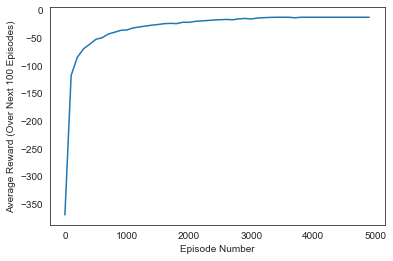

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  2  1  1  1  1  2  1  1  1  2  2]
 [ 3  3  1  1  1  3  2  1  2  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]


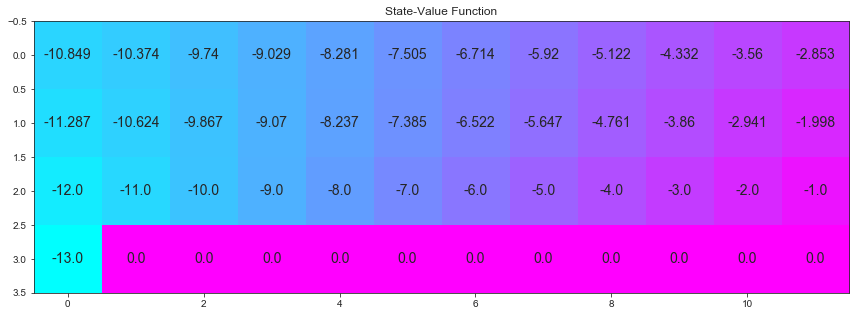

In [14]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsa = sarsa(env, 5000, .01)

# print the estimated optimal policy
policy_sarsa = np.array([np.argmax(Q_sarsa[key]) if key in Q_sarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_sarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsa)

# plot the estimated optimal state-value function
V_sarsa = ([np.max(Q_sarsa[key]) if key in Q_sarsa else 0 for key in np.arange(48)])
plot_values(V_sarsa)

### Part 2: TD Control: Q-learning

In this section, you will write your own implementation of the Q-learning control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [15]:
def update_Q_sarsamax(alpha, gamma, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]  # estimate in Q-table (for current state, action pair)
    Qsa_next = np.max(Q[next_state]) if next_state is not None else 0  # value of next state 
    target = reward + (gamma * Qsa_next)               # construct TD target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [16]:
def q_learning(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Q-Learning - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): learning rate
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        score = 0                                              # initialize score
        state = env.reset()                                    # start episode
        eps = 1.0 / i_episode                                  # set value of epsilon
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            Q[state][action] = update_Q_sarsamax(alpha, gamma, Q, \
                                                 state, action, reward, next_state)        
            state = next_state                                 # S <- S'
            if done:
                tmp_scores.append(score)                       # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function. 

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

Episode 5000/5000

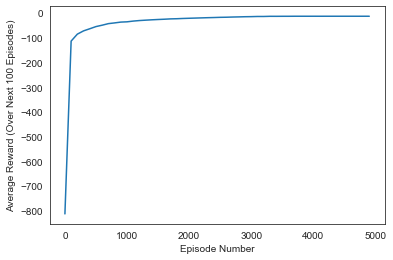

Best Average Reward over 100 Episodes:  -13.0


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 0  3  2  2  1  2  1  0  1  3  1  2]
 [ 0  1  1  1  1  1  1  1  2  2  2  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


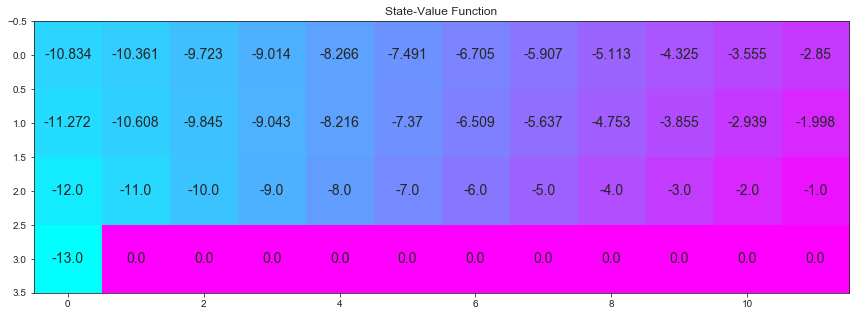

In [17]:
# obtain the estimated optimal policy and corresponding action-value function
Q_sarsamax = q_learning(env, 5000, .01)

# print the estimated optimal policy
policy_sarsamax = np.array([np.argmax(Q_sarsamax[key]) if key in Q_sarsamax else -1 for key in np.arange(48)]).reshape((4,12))
check_test.run_check('td_control_check', policy_sarsamax)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_sarsamax)

# plot the estimated optimal state-value function
plot_values([np.max(Q_sarsamax[key]) if key in Q_sarsamax else 0 for key in np.arange(48)])

### Part 3: TD Control: Expected Sarsa

In this section, you will write your own implementation of the Expected Sarsa control algorithm.

Your algorithm has four arguments:
- `env`: This is an instance of an OpenAI Gym environment.
- `num_episodes`: This is the number of episodes that are generated through agent-environment interaction.
- `alpha`: This is the step-size parameter for the update step.
- `gamma`: This is the discount rate.  It must be a value between 0 and 1, inclusive (default value: `1`).

The algorithm returns as output:
- `Q`: This is a dictionary (of one-dimensional arrays) where `Q[s][a]` is the estimated action value corresponding to state `s` and action `a`.

Please complete the function in the code cell below.

(_Feel free to define additional functions to help you to organize your code._)

In [21]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = Q[state][action]         # estimate in Q-table (for current state, action pair)
    policy_s = np.ones(nA) * eps / nA  # current policy (for next state S')
    policy_s[np.argmax(Q[next_state])] = 1 - eps + (eps / nA) # greedy action
    print(policy_s, Q[next_state])
    Qsa_next = np.dot(Q[next_state], policy_s)         # get value of state at next time step
    target = reward + (gamma * Qsa_next)               # construct target
    new_value = current + (alpha * (target - current)) # get updated value 
    return new_value

In [22]:
def expected_sarsa(env, num_episodes, alpha, gamma=1.0, plot_every=100):
    """Expected SARSA - TD Control
    
    Params
    ======
        num_episodes (int): number of episodes to run the algorithm
        alpha (float): step-size parameters for the update step
        gamma (float): discount factor
        plot_every (int): number of episodes to use when calculating average score
    """
    nA = env.action_space.n                # number of actions
    Q = defaultdict(lambda: np.zeros(nA))  # initialize empty dictionary of arrays
    
    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        score = 0             # initialize score
        state = env.reset()   # start episode
        eps = 0.005           # set value of epsilon
        
        while True:
            action = epsilon_greedy(Q, state, nA, eps)         # epsilon-greedy action selection
            next_state, reward, done, info = env.step(action)  # take action A, observe R, S'
            score += reward                                    # add reward to agent's score
            # update Q
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, \
                                                 state, action, reward, next_state)        
            state = next_state              # S <- S'
            if done:
                tmp_scores.append(score)    # append score
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # plot performance
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return Q

Use the next code cell to visualize the **_estimated_** optimal policy and the corresponding state-value function.  

If the code cell returns **PASSED**, then you have implemented the function correctly!  Feel free to change the `num_episodes` and `alpha` parameters that are supplied to the function.  However, if you'd like to ensure the accuracy of the unit test, please do not change the value of `gamma` from the default.

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [0. 0.

[0.00125 0.99625 0.00125 0.00125] [  -3.00144161   -2.13048694 -103.12872404   -2.13157112]
[0.99625 0.00125 0.00125 0.00125] [  -1.00375626   -2.13064801 -103.25422359   -2.13157693]
[0.00125 0.00125 0.99625 0.00125] [-2.00624241 -2.00000939 -1.13157404 -3.0053336 ]
[0.00125 0.99625 0.00125 0.00125] [  -2.13609512   -2.13064801 -103.25422359   -2.13157693]
[0.99625 0.00125 0.00125 0.00125] [  -1.00375626   -2.13078912 -103.38292844   -2.13173381]
[0.00125 0.00125 0.00125 0.99625] [-1.00375    -2.00000939 -1.13173492 -1.00250626]
[0.00125 0.99625 0.00125 0.00125] [-2.00624241 -2.00000939 -3.25706045 -3.0053336 ]
[0.99625 0.00125 0.00125 0.00125] [-1.00375    -2.00000939 -1.13173492 -3.00284515]
[0.00125 0.00125 0.00125 0.99625] [-2.00000313 -2.00000313 -2.00142247 -1.0025    ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126136 -2.00250313 -2.00142227 -3.00517015]
[0.99625 0.00125 0.00125 0.00125] [-2.00624241 -2.00765417 -3.25706045 -3.0053336 ]
[0.00125 0.99625 0.00125 0.00125] [-3.001261

[0.00125 0.00125 0.00125 0.99625] [-6.00272925 -6.00526357 -5.12834708 -5.01788821]
[0.00125 0.00125 0.00125 0.99625] [-6.00510048 -6.00272925 -6.00177941 -5.01492896]
[0.00125 0.00125 0.99625 0.00125] [-6.02022725 -6.00510048 -6.00139296 -6.01739707]
[0.99625 0.00125 0.00125 0.00125] [-6.01739707 -6.12944549 -7.13720696 -6.02009897]
[0.00125 0.99625 0.00125 0.00125] [-6.02022725 -6.00510048 -7.01894027 -6.01739707]
[0.00125 0.00125 0.99625 0.00125] [-6.00510048 -6.00272925 -6.00177941 -7.00144114]
[0.99625 0.00125 0.00125 0.00125] [-6.00255797 -6.02055932 -7.12461973 -7.00141671]
[0.00125 0.99625 0.00125 0.00125] [-6.00510048 -6.00272925 -7.00523162 -7.00144114]
[0.00125 0.00125 0.99625 0.00125] [-6.00272925 -6.00526357 -5.12834708 -6.01863499]
[0.00125 0.00125 0.00125 0.99625] [-6.02049155 -6.01130441 -6.25903818 -6.01093751]
[0.00125 0.99625 0.00125 0.00125] [-7.00523373 -6.02055932 -7.12461973 -7.00141671]
[0.00125 0.99625 0.00125 0.00125] [-6.02049155 -6.01130441 -6.25903818 -7.02

[0.99625 0.00125 0.00125 0.00125] [-9.0078036  -9.00886565 -9.13074913 -9.00957317]
[0.00125 0.99625 0.00125 0.00125] [ -9.01156694  -9.00800307  -9.26167219 -10.00544787]
[0.00125 0.99625 0.00125 0.00125] [-8.00938591 -8.00811005 -8.15487786 -9.01156694]
[0.00125 0.99625 0.00125 0.00125] [-8.00811005 -7.39585531 -7.39898385 -9.00472187]
[0.99625 0.00125 0.00125 0.00125] [-7.00262301 -7.00291216 -7.26104028 -8.00309938]
[0.99625 0.00125 0.00125 0.00125] [-7.00262301 -7.00291216 -7.26104028 -8.00309938]
[0.00125 0.00125 0.00125 0.99625] [-7.00291216 -6.01545291 -6.26537524 -6.01265688]
[0.00125 0.99625 0.00125 0.00125] [-8.00419699 -7.01421409 -7.26104028 -8.00309938]
[0.00125 0.99625 0.00125 0.00125] [-7.00291216 -6.01545291 -6.26537524 -8.01699621]
[0.00125 0.00125 0.99625 0.00125] [-6.00380955 -5.14753165 -5.13583469 -6.0116054 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.0058398  -5.37760296 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.00284283 -4.25242441 -

[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -1.0012547  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.21697191 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.1041813  -101.25094259  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -10.98835433 -102.12703395  -12.48400131]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.86928819 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.74723765 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.62579896 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -7.27862243   -6.50372312 -103.25422359   -6.63898979]
[0.00125 0.99625 0.00125 0.00125] [  -6.14630699   -5.37760296 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.01092435   -4.25242441 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.2645

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.74845826 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.62702417 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -7.27862243   -6.50495295 -103.25422359   -6.63898979]
[0.00125 0.99625 0.00125 0.00125] [  -6.14630699   -5.37883741 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.01092435   -4.2536635  -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12534259 -104.3835333    -4.38468755]
[0.00125 0.99625 0.00125 0.00125] [  -2.00781783   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.21697191 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.1041813  -101.25094259  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.0155

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.87141635 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.74937381 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.62794317 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.50495295 -103.25422359   -6.63898979]
[0.00125 0.99625 0.00125 0.00125] [  -6.14630699   -5.37883741 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.01092435   -4.2536635  -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12534259 -104.3835333    -4.38468755]
[0.00125 0.99625 0.00125 0.00125] [  -2.00781783   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.21907622 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.2833

[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -10.99047451 -102.12703395  -12.48400131]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.87141635 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.74937381 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.62794317 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.50495295 -103.25422359   -6.63898979]
[0.00125 0.99625 0.00125 0.00125] [  -6.14630699   -5.37883741 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.01092435   -4.2536635  -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12534259 -104.3835333    -4.38468755]
[0.00125 0.99625 0.00125 0.00125] [  -2.00781783   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.5

[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -10.99308292 -102.12703395  -12.48400131]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.87403458 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7520019  -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63303773 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.50741878 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -6.14630699   -5.38131253 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.01092435   -4.25614793 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -4.38468755]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.5

[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.24042458 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.1113121  -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -10.99551198 -102.12703395  -12.48400131]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.87647277 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.75552148 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63411398 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.50849907 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38131253 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.01092435   -4.25614793 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -4.38468755]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13

Episode 200/5000[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.2414808  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.11237229 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -10.99657616 -102.12703395  -12.48400131]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.87754096 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.75552148 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63411398 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.50849907 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38131253 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.01092435   -4.25614793 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -4.38468755]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.87876971 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.75675486 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63658535 -103.12872404   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51097975 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38380255 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.25739527 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -5.38255988]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.24269577 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.2833

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.25772906 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.12868172 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -11.01294698 -102.12703395  -12.48400131]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.8939734  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77201578 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63658535 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51097975 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38380255 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.25739527 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -5.38255988]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.25772906 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.12964888 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -11.01294698 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.8939734  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77201578 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63658535 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.2586926  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.12964888 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -11.01294698 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.8939734  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77201578 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63658535 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51097975 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38380255 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63658535 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51097975 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38380255 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.25739527 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -5.38255988]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.2586926  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.12964888 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -11.01294698 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.25739683 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -2.13454778]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.2586941  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.12965039 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -11.0129485  -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.89397493 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77201731 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63658689 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138

Episode 300/5000[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.2586941  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.12965039 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -11.0129485  -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.89397493 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77201731 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63658689 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5109813  -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38380409 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.25739683 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.12783637 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.89656934 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -103.12501915  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63920087 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.26125944 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.2833

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.26125944 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.13222538 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -11.01559939  -11.01553318 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63920087 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743036 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.01709507  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63920087 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.2764074  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743036 -114.32982824  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.01709507  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.27648738 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743925 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63920087 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138

[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743925 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63920087 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.002506

Episode 400/5000[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.27648738 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743925 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63920087 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.

[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.27648738 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743925 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-13.52861217 -13.27648738 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743925 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26004044 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13048993 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-1.00375626 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.27648738 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743925 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00125784 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.27648738 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14743925 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.02953881 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91062769 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77462149 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.63920087 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51360512 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38643779 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788937  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985463 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196328 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91306128 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706424 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165282 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5160663  -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.0105

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165282 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5160663  -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788937  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985463 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196328 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

Episode 500/5000[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788937  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985463 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196328 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91306128 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706424 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165282 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5160663  -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01054344   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [-6.15139117 -6.01003842 -6.26029276 -7.0026133 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.00707425 -5.37760296 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.00408193 -4.25242441 -5.01000175]


[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [-12.00972989 -11.02117354 -11.60008065 -11.88019513]
[0.00125 0.99625 0.00125 0.00125] [-10.40707657 -10.01778234 -10.62209327 -11.73714078]
[0.00125 0.99625 0.00125 0.00125] [-10.15445334  -9.01447855  -9.50181476 -10.03020065]
[0.00125 0.99625 0.00125 0.00125] [-8.02950527 -8.01504242 -8.39272991 -8.1446251 ]
[0.00125 0.99625 0.00125 0.00125] [-8.02226386 -7.01176865 -7.62579896 -8.00626195]
[0.00125 0.99625 0.00125 0.00125] [-6.15139117 -6.01003842 -6.26029276 -7.0026133 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.00707425 -5.37760296 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.00408193 -4.25242441 -5.01000175]
[0.00125 0.99625 0.00125 0.00125] [-3.007494

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.2833

[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.0117

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.0242

[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.00980506 -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138

Episode 600/5000[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64165435 -114.35447233   -8.2550183 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2788952  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -12.28331951  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.0242

[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.74937381]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.27982722 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.14985613 -114.38673024  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.27983355 -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.14985613 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03196478 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9130628  -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77706576 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64168896 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2819092  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.1519396  -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03405609 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64168896 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2819092  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.1519396  -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03405609 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2819092  -14.30480571 -14.02518369]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.1519396  -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03405609 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91516198 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77917285 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64168896 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77917285 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64168896 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2819092  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.1519396  -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.0242

[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2819092  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.1519396  -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03405609 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91516198 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77917285 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64168896 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.0117

[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03405609 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91516198 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77917285 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64168896 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [ -14.

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.77917285 -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64168896 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51606783 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.38890823 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26252018 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -3.26453719   -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2819092  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.1519396  -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.0242

[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.2819092  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.1519396  -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03405609 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91516198 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91730417 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.28402738 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0289

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.15406575 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03619025 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91730417 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.28402738 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.15406575 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.03619025 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91730417 -102.37407228  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.0117

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91730417 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29896497 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0289

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29896497 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16905956 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02420665  -11.0512405  -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91730417 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.37169568  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29896647 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16906107 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29903742 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29903742 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91737592 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29903742 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29903742 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91737592 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29903742 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91737592 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91737592 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29903742 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91737592 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64384731 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.5182343  -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108286 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470299 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13297901 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00375629 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.0000094  -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
Episode 800/5000[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29903742 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91737592 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.7813231  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.0

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913228 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131199 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91737592 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.78132768 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64385191 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51823891 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108749 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470764 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13298368 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.29904193 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913681 -114.39178971  -13.01077324]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131653 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91738049 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.78132768 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64385191 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51823891 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108749 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91738049 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.78132768 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64385191 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51823891 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108749 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470764 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13298368 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.30065649 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0289

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913681 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131653 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91738049 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.78132768 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64385191 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51823891 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108749 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470764 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13298368 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51823891 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108749 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470764 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13298368 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.30065649 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913681 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131653 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91738049 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64385191 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51823891 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108749 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.26470764 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.13298368 -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -101.12920937   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.30065649 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913681 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131653 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.30065649 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.16913681 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.05131653 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.91738049 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.78132768 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.64385191 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0138218    -6.51823891 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.39108749 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3167367  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.18527755 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3167367  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.18527755 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3167367  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.18527755 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3167367  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.18527755 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -102.12703395  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
Episode 900/5000[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.0

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.0117

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33207865 -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20067724 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06751803 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93364296 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79765137 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66023704 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.77706576]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3321039  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20070259 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06754347 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9336685  -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.797677   -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66026277 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3321039  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20070259 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06754347 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9336685  -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.797677   -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66026277 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.0117

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20070259 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06754347 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9336685  -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.797677   -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66026277 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3321039  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20070259 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06754347 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9336685  -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3321039  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20070259 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06754347 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9336685  -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.797677   -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66026277 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20070259 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06754347 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9336685  -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.797677   -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66026277 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53467958 -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40759005 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.38380255]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28127231 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3321039  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20070259 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06754347 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3321039  -14.30480571 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20073155 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06757254 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93369768 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79770629 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66029217 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.5347091  -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40761967 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28130205 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06757254 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93369768 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.79770629 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66029217 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.5347091  -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.40761967 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28130205 -103.49565233   -4.39354179]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33213275 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20073155 -114.39178971  -14.30242517]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.06757254 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93633422 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80035276 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.6629486  -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53737552 -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.0117

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.6629486  -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53737552 -103.25422359   -8.79765137]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.41029613 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28130205 -103.49565233   -6.5347091 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.43082903   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.334786   -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20334835 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07019919 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33478932 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20335168 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07020253 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93633757 -114.41427318  -11.97022939]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80035612 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66295197 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53737552 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.41029613 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28130205 -103.49565233   -6.5347091 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.1496107  -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.41029613 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28130205 -103.49565233   -6.5347091 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33507854 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20364199 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07049393 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93633757 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80035612 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66299592 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53741963 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.41034041 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.5347091 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33512167 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20368528 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07053739 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07053739 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93638119 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8003999  -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66299592 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53741963 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.41034041 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.5347091 ]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33512167 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20368528 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07053739 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93638453 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33512497 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20368859 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07054071 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93638453 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80040325 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66299928 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07054071 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93638453 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80040325 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66299928 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80040325 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66299928 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33512497 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20368859 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20368859 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07054071 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93638453 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80040325 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66299928 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -103.25422359   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33512497 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.20368859 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.07054071 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.93638453 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.80040325 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.66299928 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81436613 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67701472 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.33512497 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08439906 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95029504 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81436613 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67701472 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81436613 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67701472 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34887958 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08439906 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95029504 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81436613 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67701472 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34887958 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08439906 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95029504 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81436613 -114.42910043  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67701472 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34887958 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.3394358 ]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08439906 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95029504 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67701472 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742301 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01176865   -5.4103438  -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134649 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.40759005]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34889719 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08439906 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53742642 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41034723 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134994 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34889719 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21749498 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08439906 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95029504 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08447065 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9503669  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81437409 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67702271 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53743103 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41034723 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134994 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [-6.15139117 -6.01373714 -6.26029276 -7.0026133 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.0107869  -5.41034723 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.00780855 -4.25242441 -5.01000175]
[0.00125 0.99625 0.00125 0.00125] [-3.00749423 -3.00625805 -3.12409883 -4.1312995 ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00376097 -2.00516292]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34896824 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.2175663  -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08447065 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9503669  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81437409 -114.48024034  -10.74

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34896824 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.2175663  -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08447065 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9503669  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81437409 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67702271 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53743103 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41034723 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134994 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.2175663  -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08447065 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9503669  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81437409 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67702271 -114.35447233   -9.91309715]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53743103 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41034723 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134994 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41034723 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134994 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34896824 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.2175663  -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08447065 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9503669  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81437409 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08451689 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95041331 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81442068 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67702271 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53743103 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41034723 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134994 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.00250626]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21761236 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08451689 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95041331 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81442068 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67702271 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53743103 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41034723 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28134994 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.14965531 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00376097 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -1.002506

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.34901413 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.21761236 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08451689 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95041331 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81442068 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.67702271 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.53743103 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.22020706 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08712136 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95302758 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81704479 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.6796567  -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.54007493 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41300108 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28401378 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3515991  -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.22020706 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08712136 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95302758 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81704479 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.6796567  -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.54007493 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41300108 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28401378 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95302758 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81704479 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.6796567  -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.54007493 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.41300108 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.28401378 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3515991  -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0289

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -104.3835333    -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3515991  -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.22020706 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.08712136 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.95302758 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.81704479 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.6796567  -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.54007493 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69213944 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55260466 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.42557798 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29663802 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.3515991  -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.22020706 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.0994642  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36384954 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.23250362 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.0994642  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96541688 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82948073 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69213944 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55260466 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.42557798 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29663802 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.4103438 ]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36384954 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.23250362 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.0994642  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96541688 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82948073 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69213944 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55260466 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36384954 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.02894076  -12.23250362 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.0994642  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96541688 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82949948 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69215827 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55262356 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.42559695 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25

[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.0107869  -5.41034723 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.0078132  -4.25242441 -5.01000175]
[0.00125 0.99625 0.00125 0.00125] [-3.00749423 -3.00625805 -3.12409883 -4.1312995 ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00376097 -2.00516292]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36386802 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23252216 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09948282 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96543557 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82949948 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69215827 -114.35447233

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09948282 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96543557 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82949948 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69215827 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55262356 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154535    -5.42559695 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36386952 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23252216 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09948282 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96543557 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82949948 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69215827 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23252216 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09948287 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96543562 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82949953 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69215832 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55262361 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.4997024 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55262361 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36410478 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36410478 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36410478 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.39178971  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.46215446 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.5164

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286418 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42559695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665706 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42557798]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29665708 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423431 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275831 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971985 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.9656735  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.8297383  -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239799 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15232919 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644491 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00375629 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423433 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275833 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971987 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96567352 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82973833 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69239801 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286421 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423433 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23275833 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09971987 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96567352 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82973833 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69240131 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286752 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42560029 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29666042 -103.49565233   -6.53741963]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15233253 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423757 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23276158 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09972313 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96567679 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82974161 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69240131 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55286752 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15233253 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36423757 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23276158 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09972313 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96569581 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82976071 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69242048 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55288676 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36425638 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23278046 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09974208 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96569581 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82976071 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69242048 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55288676 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.4256196  -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0088086    -4.29666042 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23278046 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09974208 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96569581 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82976071 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69242048 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55288676 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42562582 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29666042 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15233253 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15233253 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36426243 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23278654 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.09974819 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -10.51647744   -9.96570194 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82976685 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69242665 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55289295 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36426243 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23278654 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.10038057 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96570194 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82976685 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69242665 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55289295 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42562582 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29666042 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15233253 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.46651945   -4.25

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55289295 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42562582 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29666042 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15233253 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.46651945   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36489009 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23341656 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.10038057 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96570194 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36489009 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23341656 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.10038057 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96570194 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82976685 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69242665 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55289295 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42562582 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29666042 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25

[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36489009 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345264 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.9657383  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980335 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345264 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.9657383  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980335 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69246328 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292972 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549428   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.9657383  -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980335 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69246328 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292972 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492604 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492605 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980336 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69246329 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292973 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492605 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49541449  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980336 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69246329 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292973 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980336 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69246329 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292973 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492605 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492716 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980336 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69246329 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292973 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292973 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492716 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980336 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.69246329 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.55292973 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492716 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980336 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.42566273 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -103.49565233   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492716 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.96573831 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.82980336 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70611117 -114.35447233   -9.9503669 ]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.56662898 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43941355 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.36492716 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.23345265 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1004168  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.0223

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.1139476  -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97932003 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84343621 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70611117 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.56662898 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43941355 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29669747 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.42559695]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84343621 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70611117 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.56664613 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37835667 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2469327  -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11396448 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97933698 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84345322 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70612825 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.56664613 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24694953 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11396448 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97933698 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84345322 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70612825 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.56664613 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97933698 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84345322 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70612825 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.56664613 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37837343 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37837343 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24694953 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11396448 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97933698 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84345322 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70612825 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01871345   -6.56664613 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37837343 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24694953 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11396448 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97933698 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84345322 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97933704 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84345328 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70612831 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56664613 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.49630858   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37837348 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11396454 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97933704 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84345328 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70612831 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56664613 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43943076 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.0223

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24696589 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11398091 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97935347 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.48024034  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.149655

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37838973 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2470024  -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11401756 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.41427318  -12.20335168]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944744 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671474 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37842611 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2470024  -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.0254

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236972 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644491 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37848026 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24705676 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11407213 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.41427318  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11407213 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.41427318  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346977 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614486 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944745 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671475 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37848027 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24705677 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11407213 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.41427318  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346978 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614487 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37848027 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24705677 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11407213 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.41427318  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346978 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614487 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944745 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671475 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37848027 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24705677 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11407213 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.41427318  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346978 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614487 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944745 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671475 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614487 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944745 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671475 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37859873 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24717568 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11419149 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.0223

[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346978 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70614487 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56666275 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43944745 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29671475 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0107869    -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37859873 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.37859873 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.24717568 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11419149 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939026 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84346978 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70615431 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56667222 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0184

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.11420082 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.97939963 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.84347918 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.70615431 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.56667222 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -103.38292844   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12790206 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99315244 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85728376 -114.50967036  -10.74986668]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72001085 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58058092 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.50988699   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39220666 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26130384 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12837283 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99362499 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85728376 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72001085 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39267391 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26130384 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12837283 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99362499 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85728376 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72001085 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58058092 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.50988699   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39267391 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26130384 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12837283 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99362499 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85728376 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72001085 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58058092 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.50988699   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0184

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39267391 -15.49554306 -14.28503188]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26130384 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12837283 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99362499 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85728376 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72001085 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26130384 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12837283 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99362499 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85728376 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72001085 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58058092 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.50988699   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.149655

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39267391 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26130384 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12837283 -114.44678887  -13.25772906]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39269114 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39285921 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26148984 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12839019 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.149655

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39285921 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26148984 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12839019 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0184

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26148984 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12839019 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.149655

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39285921 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26148984 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12839019 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12839019 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.50967036  -11.12790206]
[0.99625 0.00125 0.00125 0.00125] [ -14.39751926 -114.49558463  -14.52342939  -15.49510059]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39285921 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26148984 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12839019 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02238801   -9.99364241 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39288163 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26151234 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12841278 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99366054 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26151234 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12841278 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99366054 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39288163 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26151234 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12841278 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99366054 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39288163 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26151234 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12841278 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99366054 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39288163 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26151234 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12841278 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99366054 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0184

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.00251274 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39288163 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26151234 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12841278 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99366054 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26151234 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12841278 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99366054 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85730125 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200284  -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58059855 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43945695 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29672429 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15236973 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00644827 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39288163 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39289238 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.6446

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
Episode 2100/5000[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39289238 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.

[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39289238 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.49630747  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39289238 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.49630747  -14.35352261]
[0.99625 0.00125 0.00125 0.00125] [ -14.3975523  -114.52419346  -14.52342939  -15.52423989]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39289238 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52427631  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39292734 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52427631  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39292734 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52427631  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39292734 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52427631  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0184

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39292734 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52427631  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39292738 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0138776  -13.39292738 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39292738 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26152313 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.44678887  -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43946799 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29673537 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15238085 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.49627178   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39302394 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26162005 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12842361 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99367141 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85731216 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72003936 -114.35447233   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58060954 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064421 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52398729   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39305783 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26165407 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12845776 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99370569 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26165407 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12845776 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99370569 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85734657 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.7200739  -114.35447233   -9.97928402]
[0.99625 0.00125 0.00125 0.00125] [ -14.39772813 -114.52419346  -14.52342939  -15.52431101]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39305783 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26165407 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02540906  -11.12845776 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [-12.00972989 -11.02605054 -11.60008065 -11.88019513]
[0.00125 0.99625 0.00125 0.00125] [-10.40707657 -10.0264855  -10.62209327 -11.73714078]


[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327226 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2618693  -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327226 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2618693  -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12866922 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99391794 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327226 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2618693  -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12866922 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99391794 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327226 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2618693  -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12866922 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99391794 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99391794 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12790206]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327226 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9939189  -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327226 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327321 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26187026 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12867017 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9939189  -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327321 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26187026 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12867017 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9939189  -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327321 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26187026 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12867017 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9939189  -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327321 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26187026 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12867017 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9939189  -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39327321 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26187026 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12867017 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0260

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12867017 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9939189  -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85755962 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72007447 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.46657122   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39334447 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26194179 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12874197 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99399097 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85763197 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39334447 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26194179 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12874197 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99399097 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85763197 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -8.64460516   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446707 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85810985 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39334447 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39381523 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26241432 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12921628 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446707 -114.50976022  -12.2470024 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85810985 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39383435 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26243351 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12923555 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446707 -114.50976022  -12.26241432]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85810985 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39383435 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26243351 -114.52431114  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12923555 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446707 -114.50976022  -12.26241432]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85810985 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0184

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446707 -114.50976022  -12.26241432]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85810985 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39383435 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26243351 -114.52522227  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12923555 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446707 -114.50976022  -12.26241432]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85810985 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014709 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.52466533   -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39383549 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26243351 -114.52522227  -14.35352261]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12923555 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446776 -114.50976022  -12.26241432]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85811055 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014779 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3938924  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2624342  -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12923624 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446776 -114.50976022  -12.26241432]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85811055 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014779 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3938924  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.2624342  -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12923624 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446776 -114.50976022  -12.26241432]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446776 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85811055 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72014779 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.80035276]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3938924  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39389243 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26243422 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12923626 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99446776 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26250535 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26250535 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26250535 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12930765 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99453942 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26250535 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99453942 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99453942 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43950279 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26250535 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12930765 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99453942 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.2967703  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15241591 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.00284283   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26250535 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12930765 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99453942 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.0187

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99453942 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85818247 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72021999 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58064479 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43951847 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29678604 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39396328 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0301

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39397856 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26252068 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12932304 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99455487 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85819798 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72023555 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58066041 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43951847 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29678604 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12932304 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99455487 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85819798 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72023555 -114.52445157   -9.97928402]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58066041 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43951847 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29678604 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12934199 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99457388 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85821707 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72023555 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58066041 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43951847 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29678604 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39399736 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26253955 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12934199 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99457388 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85821707 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72023555 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58066041 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12934199 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99457388 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85821707 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72023555 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58066041 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43951847 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29678604 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26253955 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12934199 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99457388 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85821707 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72023555 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58066041 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43951847 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29678604 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.48292203   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39399736 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26253955 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12934199 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99457388 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85821707 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72023555 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58066041 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29683912 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25

[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12939388 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462597 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29683912 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39404887 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12939388 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462597 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29683912 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.99625 0.00125 0.00125 0.00125] [ -14.39871545 -114.52419346  -14.52342939  -15.52431101]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39404887 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03013866  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [-13.00792483 -12.02902534 -12.83563504 -14.01635003]
[0.00125 0.99625 0.00125 0.00125] [-12.00972989 -11.02984407 -11.60008065 -11.88019513]
[0.00125 0.99625 0.00125 0.00125] [-10.40707657 -10.

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405337 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12939388 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462597 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29683912 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405337 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405337 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12939388 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462597 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29683912 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.5243221    -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405337 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405337 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259125 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12939388 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462597 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29683912 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462597 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85826936 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72028804 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071309 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957135 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29683912 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243171 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405337 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405337 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259413 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12939677 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462887 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85827226 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72029095 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071602 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071602 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957429 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29684207 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405623 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259413 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12939677 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99462887 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85827226 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72029095 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58071602 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957429 -114.52445157   -7.69215832]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29684207 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405623 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26259413 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58075119 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957429 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29684207 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39405623 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26262864 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12943141 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99466364 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26262864 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12943141 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99466364 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85830717 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72032599 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58075119 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957429 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29684207 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39409062 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26262864 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12943141 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99466364 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85830717 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72032599 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58075119 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0154

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39409062 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26262864 -114.52522227  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12943141 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99466364 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85830717 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72032599 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58075119 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957429 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29684207 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12943141 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99466364 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85830717 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72032599 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58075119 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43957429 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29684207 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.25739683]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15243467 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39409062 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26262864 -114.52522227  -14.39850356]
[0.99625 0.00125 0.00125 0.00125] [ -14.39875704 -114.52419346  -15.52543518  -15.52431101]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39409062 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26262864 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12947944 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39414017 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26267649 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12947944 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99471185 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85835555 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72037456 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58079994 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12947944 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99471185 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85835555 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72037456 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58079994 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72037456 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58079994 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39414017 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26267649 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12947944 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0260

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12947944 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99471185 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85835555 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72037456 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58079994 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.01549887   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12947944 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99471185 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85836496 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.720384   -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39414944 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26268579 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12948878 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99472122 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85836496 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85836496 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.720384   -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39414944 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26268579 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12948878 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99472122 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85836496 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.720384   -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39414944 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26268579 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12948878 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99472122 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85836496 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.720384   -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0230

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99472122 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85836496 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.720384   -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.01875866   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39414944 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99472122 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85836496 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.720384   -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39414944 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039345 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269509 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949811 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0260

[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269509 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949811 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947306  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837437 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039345 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0230

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269509 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949811 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947306  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837437 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039345 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947306  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837437 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039345 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269509 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949811 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947306  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837437 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837437 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039345 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080942 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962323 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269509 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689119 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43941355]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269509 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949811 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947306  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837437 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039345 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415871 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269509 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949811 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947306  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837437 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039345 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080968 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962349 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689145 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837463 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039371 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080968 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962349 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689145 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415896 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269535 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473086 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837463 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039371 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080968 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962349 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689145 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415896 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949837 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473086 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837463 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039371 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080968 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962349 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689145 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080968 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962349 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689145 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415896 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269535 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949837 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473086 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415896 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269535 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949837 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473086 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837463 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039371 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080968 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962349 -114.52445157   -7.72029095]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689145 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689145 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01842237   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415896 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269535 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949837 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473086 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837463 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039371 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269548 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.1294985  -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473098 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837476 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039384 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080981 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962349 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689147 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248398 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29684207]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3941591  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269549 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949851 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.994731   -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837477 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039385 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080983 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.4396235  -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3941591  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269549 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949851 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473106 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837483 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

Episode 2900/5000[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415916 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269555 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949857 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473106 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837483 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415916 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269555 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949857 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473106 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837483 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39415916 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269555 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12949857 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473106 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837483 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.52445157   -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950149 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473399 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837777 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.01548384 -4.25242441 -5.01000175]
[0.00125 0.99625 0.00125 0.00125] [-5.00503247 -3.01145125 -3.12409883 -4.1312995 ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00645943 -4.00904494]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950149 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473399 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837777 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950149 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473399 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837777 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.01548384 -4.25242441 -6.02139591]
[0.00125 0.99625 0.00125 0.00125] [-5.00503247 -3.01145125 -3.12409883 -4.1312995 ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00645943 -4.00904494]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950149 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473399 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837777 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.

[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950149 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473399 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837777 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.0230

[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950149 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0260

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837777 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269846 -114.52672913  -14.39850356]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950149 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473399 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837777 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85811055]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039391 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416205 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416279 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.52672913  -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416279 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416279 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.52672913  -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416279 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.52672913  -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416279 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416279 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.52672913  -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416279 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.52672913  -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.149655

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0230

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962356 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689153 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248404 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00645943 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.14965531]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416289 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26269879 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950182 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473432 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85837811 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039424 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58080989 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962706 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689504 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473776 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838156 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039771 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081337 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962706 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689504 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416629 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962706 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689504 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.52538406   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416629 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.2627022  -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950525 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473776 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838156 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416629 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.2627022  -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950525 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473951 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838332 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039948 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081514 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962884 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689682 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.52681058   -5.43962323]
[0.99625 0.00125 0.00125 0.00125] [ -14.39883243 -114.52677831  -15.52543518  -15.52

[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962884 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689682 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.52681058   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
Episode 3200/5000[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416802 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270394 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950699 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473951 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838332 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081514 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962884 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689682 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.5268123    -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416802 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270394 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950699 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473951 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270394 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.129507   -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473951 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838332 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039948 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081514 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962884 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689682 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.5268123    -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689147]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.152484

[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248756 -114.5268123    -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416802 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270394 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.129507   -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473951 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838332 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039948 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081514 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0230

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270394 -114.5268071   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.129507   -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473952 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838333 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039949 -114.5268035    -9.99455487]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081515 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962885 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689683 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248757 -114.5268123    -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.152484

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416804 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270395 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.129507   -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473975 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838356 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039949 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081515 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962885 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689683 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248757 -114.5268123    -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473975 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838356 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039949 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081515 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962885 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689683 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248757 -114.5268123    -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416826 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416826 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270418 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950723 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473975 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838356 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039949 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081515 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962885 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416826 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270418 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950723 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473975 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838356 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72039949 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081515 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43962885 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689683 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01843341   -3.15248757 -114.5268123    -5.43962323]
[0.99625 0.00125 0.00125 0.00125] [ -14.3988344  -114.52677831  -15.52543518  -15.52

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270418 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950723 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99473975 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838356 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72040105 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081672 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.152484

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3941698  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270572 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950878 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947413  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838512 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72040105 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081672 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0230

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838512 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72040105 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081672 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3941698  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270572 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3941698  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270572 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950878 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947413  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838512 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72040105 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.3941698  -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270572 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950878 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.9947413  -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838512 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02691391   -7.72040105 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [-8.02950527 -8.02631489 -8.39272991 -8.1446251 ]
[0.00125 0.99625 0.00125 0.00125] [-8.02226386 -7.02308354 -7.62579896 -8.00626195]
[0.00125 0.99625 0.00125 0.00125] [-6.15139117 -6.02139591 -6.26029276 -7.0026133 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.01969765 -5.41034723 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.01548384 -4.25242441 -6.02139591]
[0.00125 0.99625 0.00125 0.00125

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040105 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081672 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416981 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270573 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950879 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0260

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416981 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270573 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950879 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474131 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838513 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040105 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081672 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081672 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02308354   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416981 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270573 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950879 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474131 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39416981 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270573 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12950879 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02267413 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0263

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00646297 -4.00904494]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040261 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248404]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39417135 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26270727 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951034 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.02601037   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418066 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418066 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418066 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39882854]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418069 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418069 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418069 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.152487

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418069 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418069 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03374138  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418069 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0337

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418545 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418545 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418545 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418545 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0072

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00644827 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418545 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474287 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838669 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040262 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081829 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963042 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689841 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248757 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646297 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418545 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271662 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951972 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474289 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838671 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040263 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081831 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963044 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951974 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474289 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838671 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040263 -114.5268035    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081831 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963044 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474289 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838675 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040263 -114.52683944   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081831 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963044 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418547 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.0375

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418551 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271668 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951978 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474293 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838675 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040263 -114.52683944   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081831 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963044 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0137

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418551 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271668 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951978 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474293 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838675 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040263 -114.52683944   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081831 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963044 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838675 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040263 -114.52683944   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081831 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963044 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
Episode 3600/5000[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418551 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271668 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39418551 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26271668 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12951978 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99474293 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.00726196   -8.85838675 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [-10.15445334  -9.02692478  -9.50181476 -10.03020065]
[0.00125 0.99625 0.00125 0.00125] [-8.02950527 -8.02756496 -8.39272991 -8.1446251 ]
[0.00125 0.99625 0.00125 0.00125] [-8.02226386 -7.02433832 -7.62579896 -8.00626195]
[0.00125 0.99625 0.00125 0.00125] [-6.15139117 -6.02265889 -6.26029276 -7.0026133 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.01970114 -5.41034723 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.01548735 -4.25242441 -

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72040263 -114.52683944   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58081831 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43963044 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.01378269   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39421384 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26274512 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12954833 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0335

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839776 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041365 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082936 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02433832   -5.43964154 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39421384 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275597 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964154 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689843 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422468 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.262756   -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955925 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478255 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839776 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52681254   -5.43962323]
[0.99625 0.00125 0.00125 0.00125] [ -14.39889872 -114.52677831  -15.52683767  -15.52679994]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422469 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275601 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955925 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478255 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839776 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041365 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082937 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964154 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689843 -114.50965424   -6.55

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0335

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646297 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.39719445]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39422477 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26275609 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12955933 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.50976022  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839785 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041373 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082945 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964162 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689851 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248759 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52669216   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424601 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277741 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958074 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424601 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277741 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958074 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478263 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.8583981  -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041399 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424626 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277766 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958099 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478289 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424626 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277766 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958099 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478289 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.8583981  -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041399 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.8583981  -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041399 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424626 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277766 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424626 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277766 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958099 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478289 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.8583981  -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041399 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424626 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277766 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958099 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478289 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.8583981  -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041399 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02631489   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424626 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277766 -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3942478  -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3942478  -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3942478  -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0335

[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3942478  -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3942478  -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0335

[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39885486]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646299 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01144013 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424788 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478444 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839966 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041556 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082971 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43964188 -114.52445157   -7.72039371]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689877 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248786 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424788 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.2627792  -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958254 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.0335

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424788 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277923 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424793 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424793 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424793 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0275

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424793 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424793 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424793 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958258 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478449 -114.52688057  -12.2624342 ]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12866922]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424793 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26277925 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958302]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204156  -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689879 -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689682]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248787 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424949 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278081 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424949 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278082 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424949 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278082 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424949 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278082 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424949 -15.49554306 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278082 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39424949 -15.52690532 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278082 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39269114]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39425143 -15.52690532 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278276 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39425143 -15.52690532 -14.3988988 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278276 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278276 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39425143 -15.52690532 -14.3989667 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278276 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958416 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03351581   -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85839971 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72041561 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58082975 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396419  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.50965424   -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39425143 -15.52690532 -14.3989667 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278276 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26278278 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12958417 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.0335266    -9.99478563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043706 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427403 -15.52690532 -14.3989667 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26280545 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960693 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480693 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043706 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26280545 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960693 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480693 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043706 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427403 -15.52690532 -14.3989667 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26280545 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960693 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480693 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427403 -15.52690532 -14.3989667 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26280545 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960693 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480693 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043706 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960693 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480693 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043706 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427403 -15.52696882 -14.3989667 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.03754638  -12.26280545 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960693 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480693 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043706 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427858 -15.52696882 -14.3989667 ]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26280545 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960693 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480693 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842108 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043706 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85837777]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427864 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628055  -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960698 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480698 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842114 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043711 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043711 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58085129 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43966352 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.55286752]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248788 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427864 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628055  -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960698 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39427864 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628055  -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12960698 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99480698 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85842114 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72043711 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088614 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396985  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431271 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628397  -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964131 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484144 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845573 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047183 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088614 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396985  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.2968988  -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [  -4.01548384   -2.00646301 -114.52690165   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431271 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628397  -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964131 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484144 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845573 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047183 -114.5268676    -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088614 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.4396985  -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431271 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26283988 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964148 -114.5243221   -13.39424949]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484161 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.8584559  -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047196 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284008 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047196 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047196 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047196 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.0196

[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047196 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689879]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047196 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39899391]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964162 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.99484175 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [ -10.0301819    -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284009 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0290

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431309 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284163 -114.5268123   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964317 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476267   -9.9948433  -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.9948433  -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969863 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689893 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01969765   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431463 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.0411

[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964317 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.9948433  -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845603 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088627 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689894 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689894 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689893]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431488 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284164 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845604 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0275

[0.00125 0.99625 0.00125 0.00125] [  -7.02434179   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689894 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.01548739 -4.25242441 -6.02139591]
[0.00125 0.99625 0.00125 0.00125] [-5.00503247 -3.01145481 -3.12409883 -4.1312995 ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00646301 -4.00904494]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39431488 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26284164 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.02906536  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.

[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689894 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285249 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845604 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285249 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845604 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088628 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285249 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845604 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088628 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088628 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689894 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285249 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088628 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689894 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285249 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0314

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285249 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845604 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088628 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845604 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088628 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689894 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248801 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52700732   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.0411

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432569 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285249 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964318 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484331 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845604 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047197 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088628 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969864 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845606 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047199 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.5252234    -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432571 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628525  -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432571 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628525  -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964319 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484332 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845606 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432791 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285472 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964541 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484555 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845829 -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0275

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432792 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285472 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964542 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432792 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285472 -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964542 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484555 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964542 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484555 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12958416]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484555 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432799 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29

[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432799 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432799 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.5270094   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432801 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432801 -15.52696882 -14.39902832]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432801 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

Episode 4500/5000[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39432801 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.2628548  -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.5243221   -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476609   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [-10.40707657 -10.03142607 -10.62209327 -11.73714078]
[0.00125 0.99625 0.00125 0.00125] [-10.15445334  -9.02817363  -9.50181476 -10.03020065]
[0.00125 0.99625 0.00125 0.00125] [-8.02950527 -8.02756846 -8.39272991 -8.1446251 ]
[0.00125 0.99625 0.00125 0.00125] [-8.02226386 -7.02434183 -7.62579896 -8.00626195]
[0.00125 0.99625 0.00125 0.00125] [-6.15139117 -6.02265893 -6.26029276 -7.0026133 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.01975678 -5.41034723 -6.00

[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.0269

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.0411

[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285817 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702269  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0314

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433137 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774481  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29

[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52696882 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.0411

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02756842   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689895 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01970118   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.01548739 -4.29689894 -6.02139591]
[0.00125 0.99625 0.00125 0.00125] [-5.00503247 -3.01145481 -3.12409883 -4.1312995 ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00646301 -4.00904494]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433138 -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285818 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964549 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484563 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.8584583  -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047423 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088629 -114.

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433145 -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04118741  -12.26285825 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964556 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.9948457  -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845836 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204743  -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969865 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.7204743  -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088629 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433145 -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26285825 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964556 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964563 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484577 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845843 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047437 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088636 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72041556]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433152 -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26285839 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.1296457  -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484584 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845851 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02692478   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433159 -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26285839 -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.1296457  -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484584 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85845851 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.0197

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702603  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0276

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702603  -13.39431301]
[0.99625 0.00125 0.00125 0.00125] [ -14.39904849 -114.52702627  -15.52700774  -15.52702604]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841

[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.0282

[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0276

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29

[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.0276

[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0314

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904323]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.0226

[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0314

[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484746 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702258   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.152487

[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.3943332  -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286    -114.52702266  -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484747 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.02916215 -13.39433321 -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286001 -114.5270284   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484747 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.0197

[0.00125 0.99625 0.00125 0.00125] [-12.00972989 -11.03476613 -11.60008065 -11.88019513]
[0.00125 0.99625 0.00125 0.00125] [-10.40707657 -10.03142608 -10.62209327 -11.73714078]
[0.00125 0.99625 0.00125 0.00125] [-10.15445334  -9.02817365  -9.50181476 -10.03020065]
[0.00125 0.99625 0.00125 0.00125] [-8.02950527 -8.02762343 -8.39272991 -8.1446251 ]
[0.00125 0.99625 0.00125 0.00125] [-8.02226386 -7.02439701 -7.62579896 -8.00626195]
[0.00125 0.99625 0.00125 0.00125] [-6.15139117 -6.02271432 -6.26029276 -7.0026133 ]
[0.00125 0.99625 0.00125 0.00125] [-6.01125584 -5.01975678 -5.41034723 -6.00369807]
[0.00125 0.99625 0.00125 0.00125] [-5.14367571 -4.01548739 -4.29689894 -6.02139591]
[0.00125 0.99625 0.00125 0.00125] [-5.00503247 -3.01145481 -3.12409883 -4.1312995 ]
[0.00125 0.00125 0.99625 0.00125] [-3.00126583 -3.0025205  -2.00646301 -4.00904494]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625

[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.03186941 -13.39433321 -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286001 -114.5270284   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484747 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.0314

[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.03186941 -13.39433321 -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286001 -114.5270284   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484747 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.0243

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.03186941 -13.39433321 -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286001 -114.5270284   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484747 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [ 

[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.03186941 -13.39433321 -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286001 -114.5270284   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.0347

[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484747 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -12.03774824  -11.12964732 -114.52702838  -13.39431301]
[0.00125 0.99625 0.00125 0.00125] [ -11.03476611   -9.99484747 -114.52688057  -12.26277925]
[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.0

[0.00125 0.99625 0.00125 0.00125] [ -10.03142605   -8.85846014 -114.52417121  -11.12964542]
[0.00125 0.99625 0.00125 0.00125] [  -9.02822841   -7.72047445 -114.52700732   -9.99473952]
[0.00125 0.99625 0.00125 0.00125] [  -8.02762343   -6.58088644 -114.52702839   -8.85842108]
[0.00125 0.99625 0.00125 0.00125] [  -7.02434183   -5.43969872 -114.52445157   -7.72047437]
[0.00125 0.99625 0.00125 0.00125] [  -6.02265889   -4.29689902 -114.5269464    -6.58085129]
[0.00125 0.99625 0.00125 0.00125] [  -5.01975678   -3.15248803 -114.52687837   -5.43962323]
[0.00125 0.99625 0.00125 0.00125] [  -4.01548739   -2.00646301 -114.52702038   -4.29689894]
[0.00125 0.00125 0.99625 0.00125] [-3.01145479 -2.00646299 -1.         -3.15248757]
[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]
[0.00125 0.99625 0.00125 0.00125] [-14.03186941 -13.39433321 -15.52702619 -14.39904849]
[0.00125 0.99625 0.00125 0.00125] [ -13.04119064  -12.26286001 -114.5270284   -14.39892387]
[0.00125 0.99625 0.00125 0.00125] [ -12.0377

[0.99625 0.00125 0.00125 0.00125] [0. 0. 0. 0.]


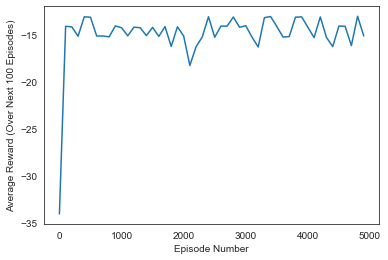

Best Average Reward over 100 Episodes:  -13.01


**<span style="color: green;">PASSED</span>**


Estimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):
[[ 1  3  1  1  1  1  3  0  1  1  1  1]
 [ 3  1  1  1  1  1  1  1  1  1  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


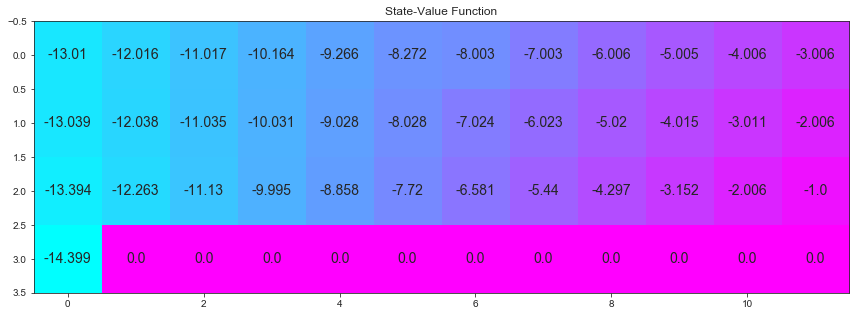

In [23]:
# obtain the estimated optimal policy and corresponding action-value function
Q_expsarsa = expected_sarsa(env, 5000, 1)

# print the estimated optimal policy
policy_expsarsa = np.array([np.argmax(Q_expsarsa[key]) if key in Q_expsarsa else -1 for key in np.arange(48)]).reshape(4,12)
check_test.run_check('td_control_check', policy_expsarsa)
print("\nEstimated Optimal Policy (UP = 0, RIGHT = 1, DOWN = 2, LEFT = 3, N/A = -1):")
print(policy_expsarsa)

# plot the estimated optimal state-value function
plot_values([np.max(Q_expsarsa[key]) if key in Q_expsarsa else 0 for key in np.arange(48)])